# Sophisticated model

Based on tensorflow tutorial for regression: https://www.tensorflow.org/tutorials/keras/regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.18.0


In [2]:
train = pd.read_csv('../data/train.gz', index_col="index")
test = pd.read_csv('../data/test.gz', index_col="index")


In [3]:
def preprocess(train_df, test_df, categorical_features, save_columns_path=None):
    """
    Preprocess training and test DataFrames for machine learning.

    This function ensures consistent preprocessing, including:
    1. Removing rows with missing values (NaN).
    2. One-hot encoding specified categorical features consistently across train and test.
    3. Removing non-numeric columns.
    4. Aligning the columns in train and test sets to ensure compatibility.
    5. Saving the training column order for consistent inference preprocessing.

    Parameters:
        train_df (pd.DataFrame): Training DataFrame.
        test_df (pd.DataFrame): Test DataFrame.
        categorical_features (list of str): List of column names to be one-hot encoded.
        save_columns_path (str, optional): Path to save the training feature column order as a file.

    Returns:
        train_features (pd.DataFrame): Preprocessed training features.
        train_labels (pd.Series): Target variable from training set ('asking_price').
        test_features (pd.DataFrame): Preprocessed test features.
        test_labels (pd.Series): Target variable from test set ('asking_price').
    """
    # Drop rows with missing values
    train_df = train_df.dropna().copy()
    test_df = test_df.dropna().copy()

    for feature in categorical_features:
        # Get dummies for train
        train_dummies = pd.get_dummies(train_df[feature], prefix=feature, dtype=int)
        # Get dummies for test
        test_dummies = pd.get_dummies(test_df[feature], prefix=feature, dtype=int)

        # Align test_dummies to match train_dummies' columns
        train_dummies, test_dummies = train_dummies.align(test_dummies, join="outer", axis=1, fill_value=0)

        # Append dummy variables to the original datasets
        train_df = pd.concat([train_df, train_dummies], axis=1)
        test_df = pd.concat([test_df, test_dummies], axis=1)

        # Drop the original categorical feature
        train_df.drop(columns=[feature], inplace=True)
        test_df.drop(columns=[feature], inplace=True)

    # Separate the target variable ('asking_price') from features
    train_labels = train_df.pop('asking_price')
    test_labels = test_df.pop('asking_price')

    # Keep only numeric columns for train and test features
    train_features = train_df.select_dtypes(include=["number"])
    test_features = test_df.select_dtypes(include=["number"])

    # Save the column order for inference preprocessing
    if save_columns_path:
        train_features.columns.to_series().to_csv(save_columns_path, index=False)

    return train_features, train_labels, test_features, test_labels


In [4]:
# Define categorical features
categorical_features = ["fuelType", "driveWheels", "manufacturer", "chassisType", "model", "color"]

# Preprocess the training and test data
train_features, train_labels, test_features, test_labels = preprocess(
    train_df=train,
    test_df=test,
    categorical_features=categorical_features,
    save_columns_path="../app/my_model/train_columns.csv"  # Save column order for inference
)

In [19]:
# After preprocessing training data
print("Training columns:", train_features.columns)


Training columns: Index(['engineVolume', 'mileage', 'modelYear', 'power', 'fuelType_diesel',
       'fuelType_electricity', 'fuelType_gasoline', 'fuelType_hybrid',
       'driveWheels_4wd', 'driveWheels_fwd',
       ...
       'color_green', 'color_grey', 'color_lilac', 'color_orange',
       'color_pink', 'color_red', 'color_silver', 'color_turquoise',
       'color_white', 'color_yellow'],
      dtype='object', length=244)


In [5]:
display(train_features.head())
print(train_features.shape)
print(test_features.shape)


,engineVolume,mileage,modelYear,power,fuelType_diesel,fuelType_electricity,fuelType_gasoline,fuelType_hybrid,driveWheels_4wd,driveWheels_fwd,...,color_green,color_grey,color_lilac,color_orange,color_pink,color_red,color_silver,color_turquoise,color_white,color_yellow
index,,,,,,,,,,,,,,,,,,,,,
0,1.6,56600.0,2011,105.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1.6,29400.0,2012,105.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.4,21300.0,2014,140.0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1.4,79695.0,2011,122.0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,1.2,52500.0,2012,86.0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0


(32679, 244)
(1367, 244)


In [6]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [7]:
normalizer.adapt(np.array(train_features))

In [8]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_percentage_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [9]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (32679, 244)           │           489 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489 (1.91 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 489 (1.91 KB)

In [10]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 37.5 s
Wall time: 2min 5s


In [11]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

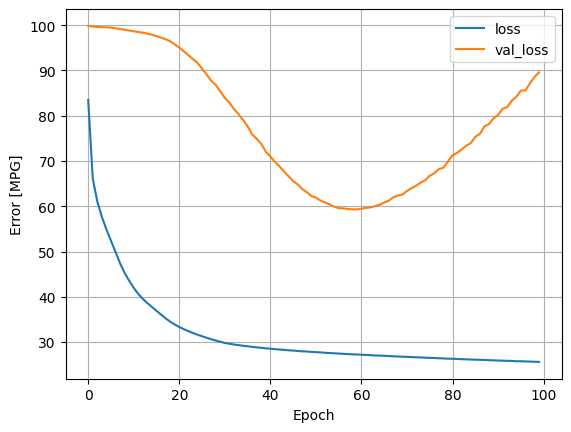

In [12]:
plot_loss(history)

In [13]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


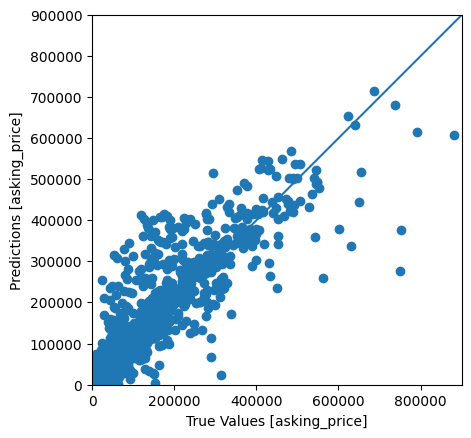

In [14]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [asking_price]')
plt.ylabel('Predictions [asking_price]')
lims = [0, 900000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

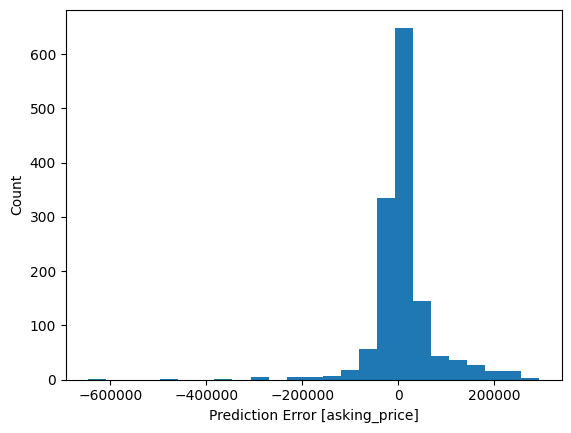

In [15]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [asking_price]')
_ = plt.ylabel('Count')

In [16]:
# Mean Absolute Percentage Error
# Calculate MAPE* (Median Absolute Percentage Error)
test_mape = np.mean(np.abs((test_labels - test_predictions) / test_labels)) * 100

test_mape_ = np.median(np.abs((test_labels - test_predictions) / test_labels)) * 100

print(f"Validation MAPE: {test_mape:.2f}%")
print(f"Validation MAPE*: {test_mape_:.2f}%")



Validation MAPE: 45.83%
Validation MAPE*: 25.40%


In [17]:
dnn_model.save("../app/my_model/dnn_model.keras")


In [18]:
train.head(1)

,chassisType,color,driveWheels,engineVolume,fuelType,manufacturer,mileage,model,modelYear,asking_price,power
index,,,,,,,,,,,
0,hatchback,white,fwd,1.6,diesel,audi,56600.0,a1,2011,115937.0,105.0
